# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [253]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [269]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

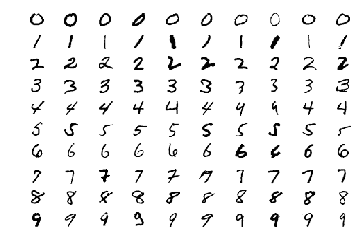

In [255]:
def P1(num_examples=10):

    # Horizontally stack mini_train_data and mini_train_labels into one array
    mini_train = np.column_stack((mini_train_data, mini_train_labels))

    # Create an array by looping through mini_train to find "num_examples" of each digit    
    # Start with a list instead of an array for efficiency
    grid_list = []
    
    # Look for each digit, 0 through 9
    for dig in range(0,10):
        i = 0
        j = 0
        
        # Use i as a counter to find "num_examples" of each digit, and j as a row indicator
        while i<num_examples:
            if mini_train[j,784]==dig:
                grid_list.extend(mini_train[j,0:784])
                i+=1
            j+=1
    
    # Reshape the list into an array with 10*num_examples rows and 784 columns
    grid = np.asarray(grid_list).reshape(10*num_examples,784)

    # Reshape each line of "grid" to a 28x28 array and plot using the "Greys" colormap to get black-and-white
    for row in range(0,grid.shape[0]):
        matrix =np.array(grid[row,:]).reshape(28,28)
        plt.subplot(10,10, row+1)
        
        # Remove axes for aesthetics!
        plt.axis('off')
        plt.imshow(matrix, cmap='Greys')

# Run the function with 10 examples
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [256]:
# Create a function that returns the accuracy score 
def P2(k_values):
    
    # Initialize a list of accuracy scores
    acc_score = []
    
    # Loop through each k in k_values
    for k in k_values:
        
        #Initialize and fit the classifier to mini training set
        KNN_model = KNeighborsClassifier(k)
        KNN_model.fit(mini_train_data, mini_train_labels)
        
        # Predict labels for the development set
        dev_pred = KNN_model.predict(dev_data)

        # Calculate accuracy score on development set and add to the acc_score list
        # NOTE: Manually calculating accuracy score for this problem, but future problems will use clf.score()
        dev_compare = np.equal(dev_pred, dev_labels)
        acc = np.sum(dev_compare)/len(dev_compare)
        acc_score.append(acc)
        
        # If k=1, also show precision, recall and F1 for each label
        if k==1:
            print(classification_report(dev_labels, dev_pred))
    
    return acc_score

k_values = [1, 3, 5, 7, 9]
P2(k_values)


             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



[0.88800000000000001,
 0.878,
 0.86899999999999999,
 0.86499999999999999,
 0.86299999999999999]

ANSWER: 9 is the most difficult digit, with the lowest f1-score.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [257]:
def P3(train_sizes, accuracies):

#Initialize list of times for each prediction
    times = []

    for n in train_sizes:
    
        # Split train_data and train_labels further into subsets of the input size
        sub_train_data = train_data[0:n-1]
        sub_train_labels = train_labels[0:n-1]

        # Create and fit the classifier to the sub-training data, using k=1
        KNN_model = KNeighborsClassifier(1)
        KNN_model.fit(sub_train_data, sub_train_labels)

        # Predict labels for the development set. Also calculate the time taken to predict (in seconds)
        start = time.time()
        dev_pred = KNN_model.predict(dev_data)
        job_time = time.time() - start

        # Calculate accuracy score on development set
        acc = KNN_model.score(dev_data, dev_labels)

        # Add acc_score and job_time to the respective lists 
        accuracies.append(acc)
        times.append(job_time)

    return accuracies, times
    
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

([0.71999999999999997,
  0.78300000000000003,
  0.83999999999999997,
  0.88400000000000001,
  0.90200000000000002,
  0.92600000000000005,
  0.93700000000000006,
  0.95899999999999996,
  0.96999999999999997],
 [0.10709071159362793,
  0.2101430892944336,
  0.48234033584594727,
  0.8506014347076416,
  1.7602441310882568,
  3.51650333404541,
  6.979929208755493,
  13.970874786376953,
  27.545470237731934])

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [259]:
def P4():
    
    # Convert train_sizes and accuracies from P3 to arrays and reshape
    train = np.array(train_sizes).reshape(9,1)
    acc = np.array(accuracies).reshape(9,1)

    # Fit the regression model
    reg_model = LinearRegression()
    reg_model.fit(train, acc)

    # Predict n=60000
    print(reg_model.predict(60000))

    # Try again, but transform the x variable train:
    reg_model2 = LinearRegression()
    reg_model2.fit(np.log(train), acc)
    
    # Predict n=60000 with the second model
    print(reg_model2.predict(np.log(60000)))

P4()

[[ 1.24471023]]
[[ 1.03438305]]


ANSWER: The prediction for n=60000 results in the accuracy being greater than 100%, which is not possible, and a straight line does not accurately show the relationship between trainset size and accuracy. Instead we would need to use logistic regression to capture the asymptotic relationship as accuracy approaches 1. The example above still produces an accuracy above 1, so some tweaking or shifting of the curve would still be needed.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


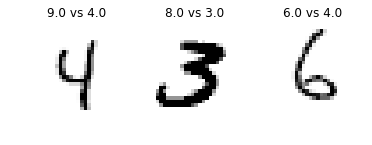

In [260]:
def P5():

    # Create and fit the classifier to the mini training dataset, using k=1
    KNN_model = KNeighborsClassifier(1)
    KNN_model.fit(mini_train_data, mini_train_labels)

    # Predict labels for the development set
    dev_pred = KNN_model.predict(dev_data)

    # Output the confusion matrix
    print(confusion_matrix(dev_labels, dev_pred))

    # Now show a few example mistakes
    # Get the indices of digits that were incorrectly predicted
    dev_inc_data = dev_data[~np.equal(dev_pred,dev_labels)]
    dev_inc_labels = dev_labels[~np.equal(dev_pred,dev_labels)]
    dev_inc_pred = dev_pred[~np.equal(dev_pred,dev_labels)]
    
    # Reshape the first 3 lines of "dev_inc" to a 28x28 array and plot using the "Greys" colormap to get black-and-white
    for row in range(0, 3):
        matrix =np.array(dev_inc[row,:]).reshape(28,28)
        
        # Create subplot of 3 examples of mistakes
        ax = plt.subplot(1, 3, row+1)
        
        # Set the title to show the actual digit vs. the mistakenly predicted digit
        title = str(dev_inc_labels[row]) + " vs " + str(dev_inc_pred[row])
        ax.set_title(title)
        
        # Remove axes for aesthetics!
        ax.axis('off')
        ax.imshow(matrix, cmap='Greys')

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Blur training data:  0.877  Blur dev data:  0.834  Blur both:  0.834


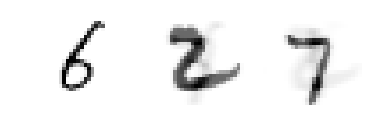

In [270]:
def P6():
    
    # First define a function that blurs any input dataset
    def Gauss_blur(data):
        
        # Initialize a smoothed array with the same values as the input data 
        data_blur = data

        # Starting with the second row and column, replace the value in that location with the weighted average of the value 
        # and the 8 surrounding values
        # We ignore the outside border since they will not have 8 surrounding pixels, and since the digits hardly touch 
        # the outside border of pixels
        for i in range(1,data.shape[0]-1):
            for j in range(1, data.shape[1]-1):
                
                # Apply half the weight of the value to the original pixel value, and the other half evenly split
                # among the surrounding 8 values
                data_blur[i,j] = 0.5 * data[i,j] + 0.5 * (data[i-1,j-1]/8 + data[i-1,j]/8 + data[i-1,j+1]/8 + 
                                                          data[i,j-1]/8 + data[i,j+1]/8 + data[i+1,j-1]/8 + data[i+1,j]/8 +
                                                          data[i+1,j+1]/8)

        return data_blur

# 1. Preprocess the training data but not the dev data
    
    # Run the mini_train_data through the Gauss_blur function
    mini_train_data_blur = Gauss_blur(mini_train_data)

    # Fit a classifier to the blurred training data
    KNN_model1 = KNeighborsClassifier(1)
    KNN_model1.fit(mini_train_data_blur, mini_train_labels)

    # Predict labels for the development set
    dev_pred1 = KNN_model1.predict(dev_data)

    # Calculate accuracy score on development set
    acc1 = KNN_model1.score(dev_data, dev_labels)

# 2. Preprocess the dev data but not the training data
    
    # Fit a classifier to the mini training data
    KNN_model2 = KNeighborsClassifier(1)
    KNN_model2.fit(mini_train_data, mini_train_labels)

    # Run the dev_data through the Gauss_blur function
    dev_data_blur = Gauss_blur(dev_data)

    # Predict labels for the development set
    dev_pred2 = KNN_model2.predict(dev_data_blur)

    # Calculate accuracy score on development set
    acc2 = KNN_model2.score(dev_data_blur, dev_labels)

# 3. Preprocess both training and dev data
    
    # Fit a classifier to the blurred mini training data
    KNN_model3 = KNeighborsClassifier(1)
    KNN_model3.fit(mini_train_data_blur, mini_train_labels)

    # Predict labels for the blurred development set
    dev_pred3 = KNN_model3.predict(dev_data_blur)

    # Calculate accuracy score on development set
    acc3 = KNN_model3.score(dev_data_blur, dev_labels)

    print("Blur training data: ", acc1, " Blur dev data: ", acc2, " Blur both: ", acc3)

# Show some examples of the blurred digits
    for row in range(0, 3):
        matrix =np.array(mini_train_data_blur[row,:]).reshape(28,28)

        # Create subplot of 3 examples
        ax = plt.subplot(1, 3, row+1)

        # Remove axes for aesthetics!
        ax.axis('off')
        ax.imshow(matrix, cmap='Greys')
    
P6()

ANSWER: The accuracy of blurring only the training data was higher than that of the other two, but sometimes did not meet the accuracy of the raw training data with k=1, depending on the mini_train_data set that was generated. Adjusting the weights of the pixels could improve the accuracy.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [271]:
def P7():

    # Create the binarized BernoulliNB classifier with the binarize argument set to split at 0.5
    BNB_model = BernoulliNB(binarize=0.5)
    
    # Fit the model on full training data and scoore on development data
    BNB_model.fit(mini_train_data, mini_train_labels)
    acc_BNB = BNB_model.score(dev_data, dev_labels)
    
    # Now try with MultinomialNB. First we need to map the pixel values to 0, 1 or 2.
    # Initialize a new feature array with the same shape as train_data
    train_data_MNB = np.zeros(mini_train_data.shape)
    
    # Loop through each element and classify them as 0, 1 or 2 based on their value in train_data
    for i in range(0,mini_train_data.shape[0]):
        for j in range(0, mini_train_data.shape[1]):
            if mini_train_data[i,j]<=0.33:
                train_data_MNB[i,j]=0
            elif mini_train_data[i,j]<=0.67:
                train_data_MNB[i,j]=1
            else:
                train_data_MNB[i,j]=2
    
    # Create the multinomial NB classifier
    MNB_model = MultinomialNB()

    # Fit the model on the modified training data and score on dev data
    MNB_model.fit(train_data_MNB, mini_train_labels)
    acc_MNB = MNB_model.score(dev_data, dev_labels)
    
    # Return the accuracy values of BernoulliNB and MultinomialNB
    return acc_BNB, acc_MNB

P7()

(0.78600000000000003, 0.66900000000000004)

ANSWER: The multinomial NB classifier actually gives a lower accuracy score than binomial in most splits of mini_train_data. This is likely due to the black-and-white, binary nature of the images.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [235]:
def P8(alphas):

    # Initialize a return vector of accuracy scores
    acc_alpha = []
    
    # Loop through each value of alpha and return an accuracy score for each
    for a in alphas['alpha']:

        #Create the Bernoulli NB classifier, using a as the alpha parameter and continuing to binarize at the 0.5 threshold
        BNB_alpha = BernoulliNB(alpha=a, binarize=0.5)

        # Fit the model on full training data and score model on dev set. Add value to the return vector
        BNB_alpha.fit(mini_train_data, mini_train_labels)
        acc_alpha.append(BNB_alpha.score(dev_data, dev_labels))

    return acc_alpha

# Replaced 0 with 0.00000001 from alpha because it gave me a divide by zero error
alphas = {'alpha': [0.00000001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

nb_best_params_ = alphas['alpha'][np.argmax(nb)]
print(nb_best_params_)

0.001


ANSWER: The accuracy of alpha seems to cap off at 85% for values below 0.001 (so any value below 0.001 would give the best accuracy). I would have expected some smoothing to increase the accuracy, but I can infer from the results that minimal smoothing gives higher accuracy of the predictions.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [288]:
def P9():

    # Fit a GaussianNB model to the mini train data
    GNB_model = GaussianNB()
    GNB_model.fit(mini_train_data, mini_train_labels)

    # Get the accuracy of the model on the dev data
    print(GNB_model.score(dev_data, dev_labels))

    # Increase the variance of the classifier (sigma) to 1
    GNB_model.sigma_ = np.ones(7840).reshape(10,784)

    # Get the updated accuracy of the model on the dev data
    print(GNB_model.score(dev_data, dev_labels))

gnb = P9()

0.524
0.734


ANSWER: Because the Gaussian model assumes the values for each pixel are normally distributed, we must force the variance of the distributions to be large enough that the actual values, which are on the tail ends of 0 and 1, are captured with large enough probability.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

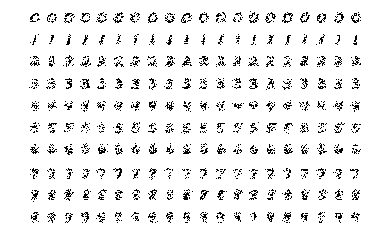

In [203]:
def P10(num_examples):

# Fit the model to training data
BNB_gen = BernoulliNB(binarize=0.5)
BNB_gen.fit(train_data, train_labels)

# Get the probability of each pixel in feature_log_prob_
prob = np.exp(BNB_gen.feature_log_prob_)

# Loop through each class (digit) and generate 20 examples of feature inputs for each digit
gen_list = []
for i in range(0,prob.shape[0]):
    
    # Create 20 examples
    for j in range(0,20):
        
        # Loop through each of the 784 pixels
        for k in range(0, prob.shape[1]):
            
            # Use the probability from the BNB_gen model to choose either 0 or 1 for the pixel value, then add to gen_list
            rand = np.random.choice([0,1],p=[1-prob[i][k], prob[i][k]])
            gen_list.append(rand)
            
# Reshape the list to an array of 200x784            
gen = np.asarray(gen_list).reshape(200,784)

# Reshape each line of "gen" to a 28x28 array and plot using the "Greys" colormap to get black-and-white
for row in range(0,gen.shape[0]):
    matrix2 =np.array(gen[row,:]).reshape(28,28)
    plt.subplot(10,20, row+1)

    # Remove axes for aesthetics!
    plt.axis('off')
    plt.imshow(matrix2, cmap='Greys')   

P10(20)

ANSWER: The images aren't as clear, but I can make out each number generated by the model. There are some digits (particularly between 8 and 9) where, if I were to create another model out of this generated data, the resulting accuracy would be very low.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [328]:
def P11(buckets, correct, total):
    
    BNB_post = BernoulliNB(alpha=1.0, binarize=0.5)
    BNB_post.fit(mini_train_data, mini_train_labels)

    # Get the posterior probabilities on dev_data
    post = BNB_post.predict_proba(dev_data)

    # Loop through each sample in the posteriors
    for row in range(0,post.shape[0]):

        # Get the max posterior probability in that row
        max_post = np.max(post[row])

        # Find the bin where the max posterior probability fits
        for i in range(len(buckets)):
            
            # Starting with the lowest bucket, if the probability is <= that bucket, add 1 to the total counter and
            # break the for loop (move on to the next sample)
            if max_post<=buckets[i] :
                
                # If that row correctly predicted the digit, also add 1 to the correct counter
                if np.argmax(post[row])==dev_labels[row]:
                    correct[i]+=1
                total[i]+=1
                
                # Break and move on to the next row so this row doesn't get counted twice
                break

    return correct, total

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   4    accuracy = 0.500
p(pred) <= 0.9000000000000    total =  78    accuracy = 0.333
p(pred) <= 0.9990000000000    total = 100    accuracy = 0.510
p(pred) <= 0.9999900000000    total =  99    accuracy = 0.545
p(pred) <= 0.9999999000000    total =  96    accuracy = 0.760
p(pred) <= 0.9999999990000    total =  87    accuracy = 0.782
p(pred) <= 0.9999999999900    total =  55    accuracy = 0.873
p(pred) <= 0.9999999999999    total =  64    accuracy = 0.938
p(pred) <= 1.0000000000000    total = 417    accuracy = 0.969


ANSWER: Since almost half the samples end up with a posterior probability of 1 and are accurately predicted 96.9% of the time, I would say this is a strongly calibrated classifier.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

0.39800000000000002

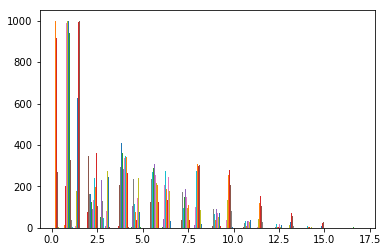

In [335]:
def P12():

    # Try summing the pixel values in each row and column as the features
    mini_train_sums = []
    
    # Calculate the sums of the rows and the columns for eachh digit
    for i in range(mini_train_data.shape[0]):
        pix = mini_train_data[i].reshape(28,28)
        row_sums = np.sum(pix, axis=1) 
        col_sums = np.sum(pix, axis=0)
        mini_train_sums.append(row_sums)
        mini_train_sums.append(col_sums)

    # Reshape mini_train_sums to have 56 features (28 row sums, 28 col sums)
    mini_train_sums = np.asarray(mini_train_sums).reshape(mini_train_data.shape[0],56)

    # Examine the histogram of mini_train_sums to determine a good binarize point. although there really isn't one
    plt.hist(mini_train_sums)

    # Train a Bernoulli Naive Bayes classifier with the binarization at 2.5. Use low alpha to reduce smoothing
    BNB_sum = BernoulliNB(alpha=0.001, binarize=2.5)
    BNB_sum.fit(mini_train_sums, mini_train_labels)

    # Sum the pixel values in dev_data and predict the labels
    dev_sums = []
    
    for i in range(dev_data.shape[0]):
        pix = dev_data[i].reshape(28,28)
        row_sums = np.sum(pix, axis=1) 
        col_sums = np.sum(pix, axis=0)
        dev_sums.append(row_sums)
        dev_sums.append(col_sums)

    # Reshape dev_sums to have 56 features
    dev_sums = np.asarray(dev_sums).reshape(dev_data.shape[0],56)
    
    # Calcualte the accuracy of the model on dev_sums
    BNB_sum.score(dev_sums, dev_labels)

    # Ultimately the accuracy was still very low due to the binarization of the sums. MultinomialNB may do a better job.
    
P12()